# **Mixed Neural Style Transfer**
adapted from PyTorch tutorial, main changes are in style loss calculation

In [4]:
# Accessing image files from my own drive
# Paths needs to be changed if running elsewhere

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img_0 = image_loader("/content/drive/MyDrive/CS_281B/style_images/mosaic_0.jpg")
style_img_1 = image_loader("/content/drive/MyDrive/CS_281B/style_images/mosaic_1.jpeg")
content_img_0 = image_loader("/content/drive/MyDrive/CS_281B/0.png")

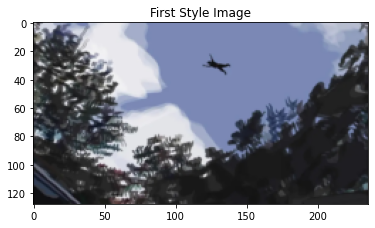

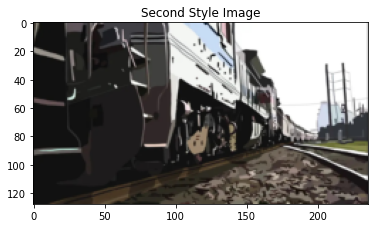

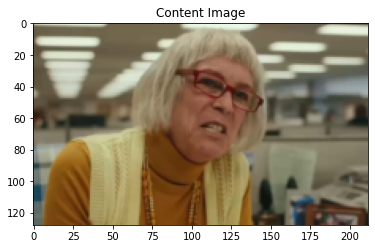

In [30]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img_0, title='First Style Image')

plt.figure()
imshow(style_img_1, title='Second Style Image')

plt.figure()
imshow(content_img_0, title='Content Image')

In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [13]:
content_layers_default = ['conv_14']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

In [14]:
i = 0
j = 1
k = 0

for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        k +=1
        name = 'conv_{}'.format(i)
        print(name,':' ,'block_',j, 'conv_',k)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
        j += 1
        k = 0
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

conv_1 : block_ 1 conv_ 1
conv_2 : block_ 1 conv_ 2
conv_3 : block_ 2 conv_ 1
conv_4 : block_ 2 conv_ 2
conv_5 : block_ 3 conv_ 1
conv_6 : block_ 3 conv_ 2
conv_7 : block_ 3 conv_ 3
conv_8 : block_ 3 conv_ 4
conv_9 : block_ 4 conv_ 1
conv_10 : block_ 4 conv_ 2
conv_11 : block_ 4 conv_ 3
conv_12 : block_ 4 conv_ 4
conv_13 : block_ 5 conv_ 1
conv_14 : block_ 5 conv_ 2
conv_15 : block_ 5 conv_ 3
conv_16 : block_ 5 conv_ 4


In [15]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img_0, style_img_1, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses_0 = []
    style_losses_1 = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img_0).detach()
            style_loss_0 = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss_0)
            style_losses_0.append(style_loss_0)

            target_feature = model(style_img_1).detach()
            style_loss_1 = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss_0)
            style_losses_1.append(style_loss_0)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses_0, style_losses_1, content_losses

In [16]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img_0, style_img_1, input_img, num_steps=50,
                       style_weight=100, style_weight_0=0.5, style_weight_1=0.5, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses_0, style_losses_1, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img_0, style_img_1, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses_0:
                style_score += sl.loss * style_weight_0
            for sl in style_losses_1:
                style_score += sl.loss * style_weight_1
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

add noise to the input image

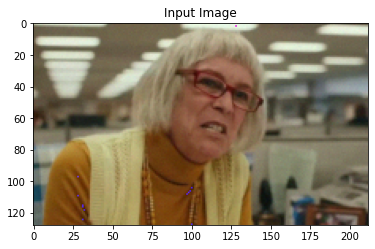

In [41]:
input_img = content_img_0.clone() + 0.01*torch.randn(content_img_0.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

In [42]:
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_0, style_img_0, style_img_1, input_img,
                            num_steps=200, style_weight=10000, style_weight_0=0.7, style_weight_1=0.3, content_weight=1)

Building the style transfer model..


<ipython-input-12-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-12-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 58.922180 Content Loss: 20.330160

run [100]:
Style Loss : 23.127655 Content Loss: 16.938826

run [150]:
Style Loss : 17.953712 Content Loss: 14.988293

run [200]:
Style Loss : 14.924543 Content Loss: 13.823162



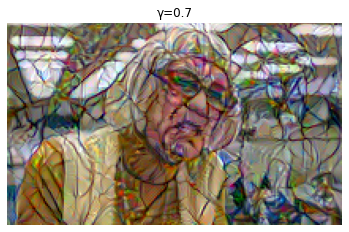

In [44]:
plt.figure()
plt.axis('off')
imshow(output, title='γ=0.7')